# Towards reproducible analysis of benthos structural complexity: A case study on Antarctic polychaete reefs using action cameras and remotely operated vehicles
- Aim: Relationships between substrate type and structural complexity
- Goal: Create a complete data pipeline for data analysis and visualization
- Authors: J.C. Montes-Herrera, G. Johnstone, J. Stark, N. Hill, V. Cummings, V. Lucieer
- Contact: juancarlos.montesherrera@utas.edu.au
- Associated publication submitted to journal Remote Sensing in Ecology & Conservation.

## Steps
1. Generate 1 x 1 meter quadrat raster files
2. Structural complexity metrics from Fukunaga et al. (2019) R script https://doi.org/10.3390/jmse7020027
3. CoralNet benthic cover annotation file
4. Data clean and export
5. Plots
6. Proceed to explore Linear Mixed Models with R code

In [1]:
## Libraries
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns

from osgeo import gdal

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["figure.figsize"] = (14, 6) ## Matplotlib figure size

## 1. Generate 1 m2 raster tiles from raster files 
- Create new folder called \rasters and download data https://doi.org/10.5281/zenodo.7115132
- Create output folder for quadrat file called \quadrats
- We assume files were exported in the following resolution.
    - Orthomosaic: 0.5 mm/pix
    - DEM: 1 cm/pix

In [ ]:
## Create a Path to the data
PATH_d = r"ant_biogenic_structures\data\rasters"

os.chdir(PATH_d)

dems = []
orthos = []

for file in glob.glob('*DEM*.tif'):
    dems.append(file)

for file in glob.glob('*ortho*.tif'):
    orthos.append(file)

In [ ]:
## Prepare PATH to generate output
PATH_o = r"ant_biogenic_structures\data\quadrats"

In [ ]:
# Process Digital Elevation Models (1 cm/pixel resolution)
for q, raster in enumerate(dems):
    dem = gdal.Open(dems[q])

    gt = dem.GetGeoTransform()

    xmin = gt[0]
    ymax = gt[3]
    res = gt[1]

    # raster lengths
    xlen = res * dem.RasterXSize
    ylen = res * dem.RasterYSize

    # number of tiles in x and y direction
    xdiv = int(xlen)
    ydiv = int(ylen)

    # size of single tile
    xsize = xlen/xdiv
    ysize = ylen/ydiv

    # create lists of x and y coordinates
    xsteps = [xmin + xsize * i for i in range(xdiv+1)]
    ysteps = [ymax - ysize * i for i in range(ydiv+1)]

    for i in range(xdiv):
        for j in range(ydiv):
            xmin = xsteps[i]
            xmax = xsteps[i+1]
            ymax = ysteps[j]
            ymin = ysteps[j+1]

            # gdal translate to subset the input raster
            gdal.Translate(PATH_o + str(dems[q][:-4]) + "_"+str(i)+str(j)+".tif", dem, projWin = (xmin, ymax, xmax, ymin), xRes = res, yRes = -res)

    #close the open dataset to flush memory
    dem = None
    

# Now the orthomosaic (0.5 cm/pixel resolution)
for q, raster in enumerate(orthos):
    ortho = gdal.Open(orthos[q])

    gt = ortho.GetGeoTransform()

    xmin = gt[0]
    ymax = gt[3]
    res = gt[1]

    # raster lengths
    xlen = res * ortho.RasterXSize
    ylen = res * ortho.RasterYSize

    # number of tiles in x and y direction
    xdiv = int(xlen)
    ydiv = int(ylen)

    # size of single tile
    xsize = xlen/xdiv
    ysize = ylen/ydiv

    # create lists of x and y coordinates
    xsteps = [xmin + xsize * i for i in range(xdiv+1)]
    ysteps = [ymax - ysize * i for i in range(ydiv+1)]

    for i in range(xdiv):
        for j in range(ydiv):
            xmin = xsteps[i]
            xmax = xsteps[i+1]
            ymax = ysteps[j]
            ymin = ysteps[j+1]

            # gdal translate to subset the input raster
            gdal.Translate(PATH_o + str(orthos[q][:-4]) + "_"+str(i)+str(j)+".tif", ortho, projWin = (xmin, ymax, xmax, ymin), xRes = res, yRes = -res)

    #close the open dataset to flush memory
    ortho = None

## 2. Structural complexity
- Once quadrats are generated and stored in "data\quadrats" they are processed to quantify structural complexity metrics
- Metrics were generated using Fukunaga et al. (2019) code https://doi.org/10.3390/jmse7020027
- Fukunaga et al. (2019) code used in this study: ant_biogenic_structures\code\Fukunaga_2019-CodeCompiled.R
- Note that this step could be performed in the same notebook using the rpy2 module (https://rpy2.github.io/).
- Resulting file '\ant_biogenic_structures\data\quadrats\habitat_complexity_16-32.csv'

In [ ]:
metrics_file = r"\ant_biogenic_structures\data\quadrats\habitat_complexity_16-32.csv"
df = pd.read_csv(metrics_file).set_index('file_name')
df.head()

In [ ]:
## Adjust index to make it prettier
df.index = df.index.str.replace(r'.tif$', '', regex=True); df.index = df.index.str.replace(r'DEM__', '', regex=True)
df.index = df.index.str.replace(r'DEM_', '', regex=True);
df_structuralcomplexity = df
df_structuralcomplexity

## 3. CoralNet annotations file, dataframe and bar plot

In [3]:
# Read CoralNet annotations raw file
df = pd.read_csv(r"\ant_biogenic_structures\data\annotations_raw.csv")
print('Number of quadrats: ' + str(df["Name"].nunique())); print('Number of different labels: ' + str(df["Label"].nunique()))
print('Number of annotations: ' + str(len(df))); print(df.shape)
#print(df) # Visualize last 5 rows

## Create frequency table - observe new dataframe has 51 rows (quadrats) and 31 columns (labels)
df = pd.crosstab(df['Name'], df['Label'])

Number of quadrats: 51
Number of different labels: 31
Number of annotations: 7650
(7650, 4)


In [4]:
## Adjust row (quadrats) names
## This will make it easier to merge with the structural metrics (it also looks better)
df.index = df.index.str.replace(r'.jpg$', '', regex=True); df.index = df.index.str.replace(r'04-ortho__', 'A-', regex=True)
df.index = df.index.str.replace(r'05-ortho_', 'B-', regex=True); df.index = df.index.str.replace(r'06-ortho_', 'C-', regex=True)
df.index = df.index.str.replace(r'07-ortho_', 'D-', regex=True); df.index = df.index.str.replace(r'09-ortho_', 'E-', regex=True)
df.index = df.index.str.replace(r'10-ortho_', 'F-', regex=True); df.index = df.index.str.replace(r'11-ortho_', 'G-', regex=True)
df.index = df.index.str.replace(r'12-ortho_', 'H-', regex=True)
#df.head()

In [5]:
## As we are not measuring biodiversity, lets keep only substrate categories.
## This also facilitates visualization.
df = df.drop(labels = ['ANEII','ASCXI','AXIX','Cri-I','HIII','SABI','SCRO','SLIV','SLXVI',
                       'SVI','SVIII','SXIV','SXV','SXXIII','WBS','WS','ASTIV',
                       'ASTVII','OIV','OEBS','REDUID','STER','Sedturfrub'], axis = 1)

df.head()

Label,BSR,MAENG,MERCC,MERNC,SCC,SERP,SUSA,UNFO
Name,,,,,,,,
A-1_00,21,0,58,0,0,30,6,12
A-1_01,46,0,65,0,0,6,9,18
A-1_10,117,0,2,0,0,30,0,0
A-1_11,29,0,43,0,0,22,9,39
A-2_00,13,0,0,0,0,116,0,18


In [6]:
## Convert frequencies to percent cover and save DataFrame
df_benthic_cover = df.apply(lambda x: x*100/sum(x), axis=1)
df_benthic_cover.head()

Label,BSR,MAENG,MERCC,MERNC,SCC,SERP,SUSA,UNFO
Name,,,,,,,,
A-1_00,16.535433,0.0,45.669291,0.0,0.0,23.622047,4.724409,9.448819
A-1_01,31.944444,0.0,45.138889,0.0,0.0,4.166667,6.250000,12.500000
A-1_10,78.523490,0.0,1.342282,0.0,0.0,20.134228,0.000000,0.000000
A-1_11,20.422535,0.0,30.281690,0.0,0.0,15.492958,6.338028,27.464789
A-2_00,8.843537,0.0,0.000000,0.0,0.0,78.911565,0.000000,12.244898


## Merge structural metrics and benthic cover data

In [75]:
## We have our two datasets ready to be merged.
df_habitat_metrics = pd.concat([df_structuralcomplexity, df_benthic_cover], axis=1)
df_habitat_metrics

,orig_area,surface16,planerS16,surface32,planerS32,max_h,min_h,fd16,fd32,surface_complexity,...,mean_profile_curvature,mean_plan_curvature,BSR,MAENG,MERCC,MERNC,SCC,SERP,SUSA,UNFO
A-1_00,1.0300,5.821141,0.9216,5.821141,0.9216,30.359108,25.954962,2.224226,2.217311,6.316342,...,45.803822,35.273526,16.535433,0.000000,45.669291,0.000000,0.000000,23.622047,4.724409,9.448819
A-1_01,1.0300,2.728238,0.9216,2.728238,0.9216,31.765301,30.216726,2.194972,2.201625,2.960328,...,4.697123,2.477279,31.944444,0.000000,45.138889,0.000000,0.000000,4.166667,6.250000,12.500000
A-1_10,1.0403,8.701784,0.9216,8.701784,0.9216,30.384106,25.770912,2.308227,2.266483,9.442040,...,108.556322,101.512511,78.523490,0.000000,1.342282,0.000000,0.000000,20.134228,0.000000,0.000000
A-1_11,1.0403,6.659451,0.9216,6.659451,0.9216,31.162127,26.774553,2.171841,2.174548,7.225967,...,24.957675,27.305298,20.422535,0.000000,30.281690,0.000000,0.000000,15.492958,6.338028,27.464789
A-2_00,1.0932,2.585702,0.8448,1.759163,0.5120,20.271091,19.179802,2.295925,2.305882,3.060726,...,9.367260,7.587447,8.843537,0.000000,0.000000,0.000000,0.000000,78.911565,0.000000,12.244898
A-2_01,1.0851,3.089361,0.9216,2.146115,0.6144,21.149029,19.961357,2.291301,2.268130,3.352171,...,7.184543,5.264532,8.510638,0.000000,0.000000,0.000000,0.000000,82.978723,0.000000,8.510638
A-2_02,1.0956,2.782415,0.9216,1.842271,0.6144,22.102070,20.879318,2.241619,2.267854,3.019114,...,3.680400,4.839574,54.761905,0.000000,0.000000,0.000000,0.000000,41.269841,0.000000,3.968254
A-2_03,1.0936,1.517664,0.7680,1.249314,0.6144,22.608173,21.743206,2.151390,2.150555,1.976124,...,0.763625,2.140945,99.122807,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.877193
A-2_04,1.0802,2.671624,0.7680,2.239882,0.6144,24.321077,22.541927,2.195721,2.189992,3.478677,...,10.289749,8.534057,89.855072,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.144928
A-2_05,1.0896,1.488236,0.8448,1.206174,0.7168,24.948872,24.042574,2.110784,2.110325,1.761643,...,0.865923,-0.341620,85.074627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.925373


## 4. Dataframe cleaning and export

In [76]:
## Discard quadrats where analysis is not optimal due to survey altitude
## This has effects in benthic classification (increasing the number of Unfocused areas)
## As well as in structural metrics increasing the error (See table with scale error)



df_clean = df_habitat_metrics.drop(['A-1_00','A-1_10','A-1_11','G-2_00', 'G-2_01'])
df_clean.shape

df_clean.to_csv(r"\ant_biogenic_structures\data\habitat_metrics.csv")

## 5. Plots
### 5.1 Benthic cover percentage

In [77]:
## Rename categories, this are CoralNet labels not useful for this anymore
## New dataframe just for plotting benthic cover, in the next step we will add structural metrics to the original dataframe
df_clean = df_clean.rename({"BSR": "Broken Polychaete Tubes", "MERCC": "Crustose Coralline Algae", "MERNC":"Encrusting Red Non-Calcareous",
                "SCC": "Cobbles","SERP": "Polychaete Colonies", "SUSA": "Mud",'MAENG':'Green Encrusting Algae','UNFO':'Unfocused'}, 
               axis='columns', errors="raise")

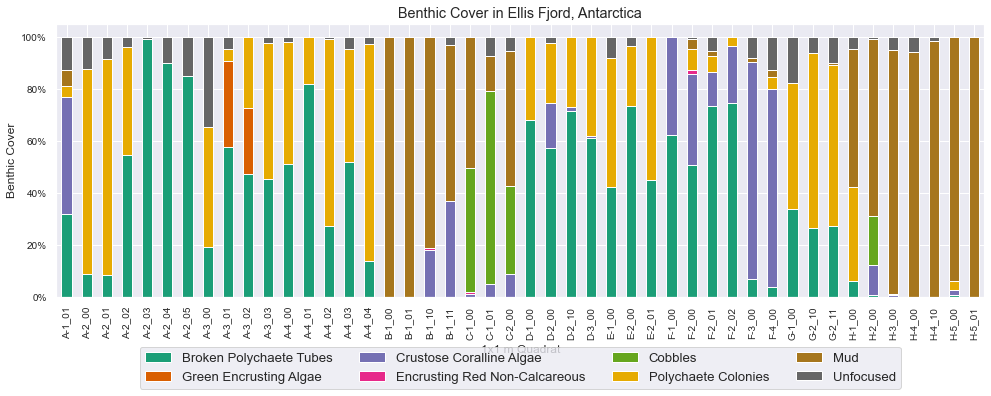

In [78]:
benthic_cover = df_clean.iloc[:, -8:] # Last 8 columns correspond to the benthic classifications

## Create plot
ax = benthic_cover.plot(kind="bar", stacked=True, title='Benthic Cover in Ellis Fjord, Antarctica', fontsize=10, cmap='Dark2') ## Bar plot
ax.set_xlabel("1x1 m Quadrat", fontdict={'fontsize':12}); ax.set_ylabel("Benthic Cover", fontdict={'fontsize':12})
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -.36),ncol = 4)
plt.tight_layout()

## Save figure in Results directory
#ax.figure.savefig(PATH_r + '/' + 'benthic-cover-plot.png')

- This figure is within associated publication as Figure 4.

### 5.2 Pearson correlation

In [79]:
## P value function
from scipy.stats import pearsonr

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [80]:
## Correlation of the full dataframe that includes structural metrics and benthic cover
df_c = df_clean.rename({"Broken Polychaete Tubes":"Broken-P", "Crustose Coralline Algae": "CCA", "Encrusting Red Non-Calcareous": "E-RedNC",
                       "Polychaete Colonies":"Polychaete-C",'Green Encrusting Algae':"E-Green", "surface_complexity":"Surface-C",
                       "mean_profile_curvature":"Mean-Profile-C","mean_plan_curvature":"Mean-Planar-C","fd32":"D32","fd16":"D16"}, 
               axis='columns', errors="raise")

df_pearson = df_c.corr(method='pearson')

## Display only structural metrics, useful to see redundancy and select the meaningful ones
structural_metrics = df_pearson.iloc[7:, 7:]
structural_metrics.style.background_gradient(cmap='coolwarm').set_precision(2)

C:\Users\jcmontes\AppData\Local\Temp\ipykernel_14308\44014547.py:11: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  structural_metrics.style.background_gradient(cmap='coolwarm').set_precision(2)


,D16,D32,Surface-C,mean_slope,Mean-Profile-C,Mean-Planar-C,Broken-P,E-Green,CCA,E-RedNC,Cobbles,Polychaete-C,Mud,Unfocused
D16,1.00,0.99,0.86,0.58,0.41,0.40,0.27,0.06,-0.39,-0.23,-0.24,0.60,-0.39,0.10
D32,0.99,1.00,0.87,0.63,0.46,0.44,0.30,0.05,-0.34,-0.25,-0.30,0.63,-0.45,0.14
Surface-C,0.86,0.87,1.00,0.79,0.48,0.46,0.39,0.01,-0.15,-0.27,-0.29,0.58,-0.58,0.13
mean_slope,0.58,0.63,0.79,1.00,0.51,0.50,0.49,0.01,0.23,-0.24,-0.22,0.50,-0.85,0.27
Mean-Profile-C,0.41,0.46,0.48,0.51,1.00,0.98,0.36,0.02,-0.17,-0.21,-0.21,0.63,-0.62,0.17
Mean-Planar-C,0.40,0.44,0.46,0.50,0.98,1.00,0.37,-0.00,-0.18,-0.20,-0.19,0.61,-0.61,0.13
Broken-P,0.27,0.30,0.39,0.49,0.36,0.37,1.00,0.13,-0.15,-0.13,-0.31,0.04,-0.67,-0.08
E-Green,0.06,0.05,0.01,0.01,0.02,-0.00,0.13,1.00,-0.10,-0.06,-0.06,-0.07,-0.13,-0.07
CCA,-0.39,-0.34,-0.15,0.23,-0.17,-0.18,-0.15,-0.10,1.00,0.14,-0.05,-0.36,-0.11,0.10
E-RedNC,-0.23,-0.25,-0.27,-0.24,-0.21,-0.20,-0.13,-0.06,0.14,1.00,0.12,-0.22,0.18,-0.16


In [81]:
df_p = calculate_pvalues(structural_metrics)
df_p

,D16,D32,Surface-C,mean_slope,Mean-Profile-C,Mean-Planar-C,Broken-P,E-Green,CCA,E-RedNC,Cobbles,Polychaete-C,Mud,Unfocused
D16,0.0,0.0,0.0,0.0005,0.0027,0.0033,0.0158,0.9006,0.0246,0.0089,0.0171,0.0,0.0046,0.384
D32,0.0,0.0,0.0,0.0002,0.0014,0.0017,0.0106,0.912,0.0379,0.007,0.0109,0.0,0.0021,0.3159
Surface-C,0.0,0.0,0.0,0.0,0.0006,0.0008,0.0029,0.9778,0.1337,0.0052,0.0088,0.0,0.0002,0.2665
mean_slope,0.0005,0.0002,0.0,0.0,0.0004,0.0005,0.0007,0.9789,0.6911,0.01,0.0168,0.0007,0.0,0.1137
Mean-Profile-C,0.0027,0.0014,0.0006,0.0004,0.0,0.0,0.0041,0.9985,0.1536,0.0136,0.0288,0.0,0.0001,0.2214
Mean-Planar-C,0.0033,0.0017,0.0008,0.0005,0.0,0.0,0.0037,0.9733,0.1533,0.0165,0.0327,0.0,0.0001,0.2614
Broken-P,0.0158,0.0106,0.0029,0.0007,0.0041,0.0037,0.0,0.4458,0.3956,0.0715,0.02,0.0461,0.0001,0.7063
E-Green,0.9006,0.912,0.9778,0.9789,0.9985,0.9733,0.4458,0.0,0.5802,0.6534,0.7011,0.8029,0.7619,0.5183
CCA,0.0246,0.0379,0.1337,0.6911,0.1536,0.1533,0.3956,0.5802,0.0,0.2134,0.5673,0.0427,0.6172,0.7663
E-RedNC,0.0089,0.007,0.0052,0.01,0.0136,0.0165,0.0715,0.6534,0.2134,0.0,0.1073,0.0105,0.0185,0.125


### 5.3 Linear models

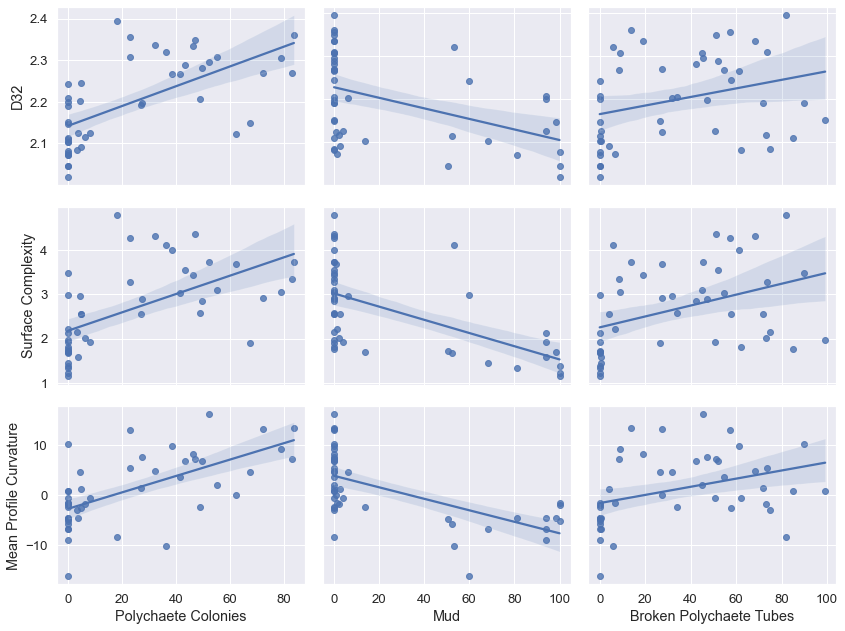

In [82]:
## Regression for main benthic cover with structural complexity metrics

sns.set(font_scale=1.2)

fig, axes = plt.subplots(3,3, sharex=False, figsize=(12,9))
## Serpulid colonies
sns.regplot(x="Polychaete Colonies", y="fd32", data=df_clean, ax=axes[(0,0)], ci=95, seed = 1).set(xlabel=None, ylabel='D32', xticklabels=[])
sns.regplot(x="Polychaete Colonies", y="surface_complexity", data=df_clean, ax=axes[(1,0)], ci=95, seed = 1).set(xlabel=None,ylabel='Surface Complexity', xticklabels=[])
sns.regplot(x="Polychaete Colonies", y="mean_profile_curvature", data=df_clean, ax=axes[(2,0)], ci=95, seed = 1).set(ylabel='Mean Profile Curvature',)
## Coralline Algae
#sns.regplot(x="Crustose Coralline Algae", y="fd32", data=df_clean, ax=axes[(0,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
#sns.regplot(x="Crustose Coralline Algae", y="surface_complexity", data=df_clean, ax=axes[(1,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
#sns.regplot(x="Crustose Coralline Algae", y="mean_profile_curvature", data=df_clean, ax=axes[(2,1)], ci=95, seed = 1).set(xlabel='Crustose Coralline Algae (CCA)',ylabel=None,yticklabels=[])
## Soft Substrate / Mud
sns.regplot(x="Mud", y="fd32", data=df_clean, ax=axes[(0,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Mud", y="surface_complexity", data=df_clean, ax=axes[(1,1)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Mud", y="mean_profile_curvature", data=df_clean, ax=axes[(2,1)], ci=95, seed = 1).set(ylabel=None,yticklabels=[])
## Broken polychaete tubes
sns.regplot(x="Broken Polychaete Tubes", y="fd32", data=df_clean, ax=axes[(0,2)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Broken Polychaete Tubes", y="surface_complexity", data=df_clean, ax=axes[(1,2)], ci=95, seed = 1).set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
sns.regplot(x="Broken Polychaete Tubes", y="mean_profile_curvature", data=df_clean, ax=axes[(2,2)], ci=95, seed = 1).set(ylabel=None,yticklabels=[])
plt.tight_layout()

#fig.savefig(PATH_r + '/' +"linear-model-plot.png")

# 6. Linear Mixed Models
- Once a complete tabular file with both structural complexity metrics and benthic cover is exported, relationships were tested in R software using linear mixed models.
- Return to Github repository to get code '\ant_biogenic_structures\code\MixedModels-JCMH.R'.
- Use file exported in step 4 '\ant_biogenic_structures\data\habitat_metrics.csv'.
- Note that this step could be performed in the same notebook using the rpy2 module (https://rpy2.github.io/).
- Resulting plots can be visualized using R Studio and ggplot.